In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn import metrics

data = pd.read_csv('dataset_sdn.csv')

##### Here we see that the label contains boolean values: 0 - Benign, 1-Maliciuous 
data.label.unique()

data.label.value_counts()

#label_dict = dict(data.label.value_counts())
#sns.countplot(x=data.label)
# plt.show()


# Assuming 'data' is the original dataframe
# Separate the data based on unique label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Resample to get equal number of rows for each label value
df_label_0_resampled = resample(df_label_0,
                                replace=False, # sample without replacement
                                n_samples=len(df_label_1), # sample same number of rows as label 1
                                random_state=42) # set random state for reproducibility

# Combine the resampled dataframes
balanced_data = pd.concat([df_label_0_resampled, df_label_1])

# Shuffle the rows to avoid any ordering bias
data = balanced_data.sample(frac=1, random_state=42)


data.label.value_counts()

df1 = data.copy()

df1 = df1.dropna()

df1.columns

#df1.info()

important_features = [
    'src',
    'pktcount',
    'dst',
    'byteperflow',
    'pktperflow',
    'pktrate',
    'tot_kbps',
    'rx_kbps',
    'flows',
    'bytecount',
    'dt',
    'Protocol',
    'dur',
    'tot_dur'
                      
                     ]


weights = [
    17.87,
    15.16,
    13.64,
    12.97,
    11.35,
    11.35,
    9.68,
    9.66,
    8.95,
    4.92,
    2.33,
    1.31,
    1.11,
    1.11
]

weighted_features = pd.DataFrame({'features':important_features,
                                 'weights':weights})
weighted_features

### But we dont need src, dst, dt, So, we will drop them
X = df1[important_features]
y = df1.label

X = X.drop(['src', 'dst', 'dt'], axis=1)

X.head()

abs(X.corr(numeric_only=True))

X = X.drop(['dur', "pktrate", "pktperflow"], axis=1)

X.columns

X = pd.get_dummies(X)

class Model:
    def __init__(self, data, y):
        self.data = data
        self.y = y
        X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, self.y, random_state=42, test_size=0.3)  
        

    def DecisionTree(self):
        start_time = time.time()
        tree = DecisionTreeClassifier()
        dt_search = GridSearchCV(tree, param_grid={'criterion' : ['gini', 'entropy'],
                                       'max_depth' : [2,3,4,5,6,7,8, 9, 10],
                                       'max_leaf_nodes' : [2,3,4,5,6,7,8,9,10, 11]},
                       n_jobs=-1, cv=5, scoring='accuracy', verbose=2)

        dt_search.fit(self.X_train, self.y_train)

        criterion = dt_search.best_params_['criterion']
        max_depth = dt_search.best_params_['max_depth']
        max_leaf_nodes = dt_search.best_params_['max_leaf_nodes']

        dtree = DecisionTreeClassifier(criterion=criterion, 
                                   max_depth=max_depth, 
                                   max_leaf_nodes=max_leaf_nodes).fit(self.X_train, self.y_train)
        predicted_dt = dtree.predict(self.X_test)
        accuracy_dt = metrics.accuracy_score(self.y_test, predicted_dt)
        print(f"criterion: {criterion}, max depth: {max_depth}, max_leaf: {max_leaf_nodes}")
        print(f"The Accuracy is : {round(accuracy_dt * 100,2)}%")
        print("------------------------------------------------------------------------")
        print(classification_report(predicted_dt, self.y_test))
        print("------------------------------------------------------------------------")

        print("--- %s seconds ---" % (time.time() - start_time))
        return dtree
    def LogisticRegression(self):
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

        start_time = time.time()
        results_lr = []
        accuracy_list = []
        for solver in solvers:
            LR = LogisticRegression(C=0.03, solver=solver).fit(self.X_train, self.y_train)
            predicted_lr = LR.predict(self.X_test)
            accuracy_lr = accuracy_score(self.y_test, predicted_lr)
            #print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))
            #print('################################################################')
            results_lr.append({'solver' : solver, 'accuracy': str(round(accuracy_lr * 100, 2)) + "%", 
                                  'Coefficients': {'W' : LR.coef_, 'b': LR.intercept_}})
            
            accuracy_list.append(accuracy_lr)
       
        solver_name = solvers[accuracy_list.index(max(accuracy_list))]
        LR = LogisticRegression(C=0.03, solver=solver_name).fit(self.X_train,self.y_train)
        predicted_lr = LR.predict(self.X_test)
        accuracy_lr = accuracy_score(self.y_test, predicted_lr)
        print("Accuracy: %.2f%%" % (accuracy_lr * 100.0), '\n')
        print("------------------------------------------------------------------------")
        print('Best solver is : ', solver_name)
        print("------------------------------------------------------------------------")
        print(classification_report(predicted_lr, self.y_test), '\n')
        print("------------------------------------------------------------------------")
        print("--- %s seconds --- time for LogisticRegression" % (time.time() - start_time))
    
        return LR


M = Model(X,y)
M.DecisionTree()
print("------------------------------------------------------------------------")
print("Linear Regression", '\n')
M.LogisticRegression()
print("------------------------------------------------------------------------")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
criterion: gini, max depth: 6, max_leaf: 11
The Accuracy is : 95.07%
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11144
           1       1.00      0.91      0.95     13199

    accuracy                           0.95     24343
   macro avg       0.95      0.95      0.95     24343
weighted avg       0.95      0.95      0.95     24343

------------------------------------------------------------------------
--- 34.37925672531128 seconds ---
------------------------------------------------------------------------
Linear Regression 

Accuracy: 73.89% 

------------------------------------------------------------------------
Best solver is :  saga
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71  

Fitting 5 folds for each of 180 candidates, totalling 900 fits
criterion: gini, max depth: 6, max_leaf: 11
The Accuracy is : 95.07%
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11144
           1       1.00      0.91      0.95     13199

    accuracy                           0.95     24343
   macro avg       0.95      0.95      0.95     24343
weighted avg       0.95      0.95      0.95     24343

------------------------------------------------------------------------
--- 29.026692152023315 seconds ---
------------------------------------------------------------------------
Linear Regression 

Accuracy: 73.89% 

------------------------------------------------------------------------
Best solver is :  liblinear
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       

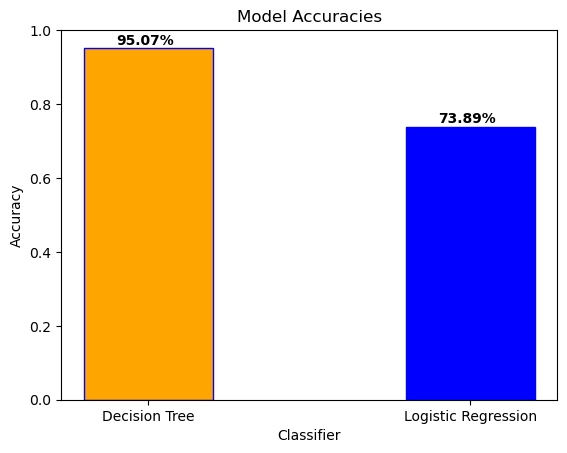

In [4]:
import matplotlib.pyplot as plt

# create instance of the class and call the methods
model = Model(X,y)
dtree = model.DecisionTree()
print("------------------------------------------------------------------------")
print("Linear Regression",'\n')
lr = model.LogisticRegression()

classifiers = ['Decision Tree', 'Logistic Regression']
accuracies = [dtree.score(model.X_test, model.y_test), lr.score(model.X_test, model.y_test)]
colors = ['orange', 'blue']
bar_width = 0.4 # adjust this value to decrease or increase the width of the bars

plt.bar(classifiers, accuracies, width=bar_width, color=colors, edgecolor='blue')
plt.title('Model Accuracies')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

for i, v in enumerate(accuracies):
    plt.text(i-bar_width/4, v+0.01, str(round(v*100,2))+'%', fontweight='bold', color='black')

plt.show()




In [5]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


Fitting 5 folds for each of 180 candidates, totalling 900 fits
criterion: gini, max depth: 6, max_leaf: 11
The Accuracy is : 95.07%
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11144
           1       1.00      0.91      0.95     13199

    accuracy                           0.95     24343
   macro avg       0.95      0.95      0.95     24343
weighted avg       0.95      0.95      0.95     24343

------------------------------------------------------------------------
--- 26.458097219467163 seconds ---
Confusion matrix, without normalization


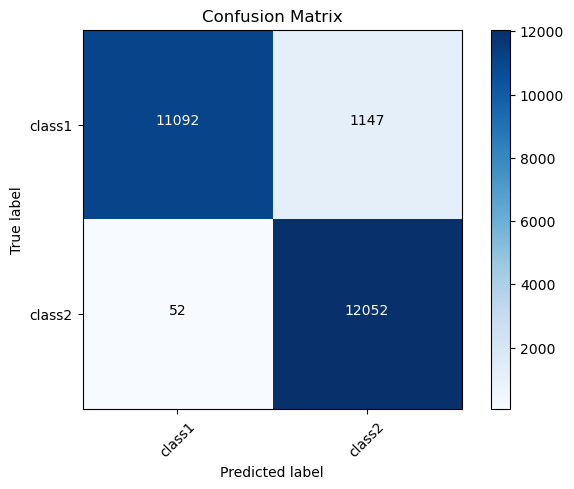

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# create instance of the class and call the methods
model = Model(X,y)
dtree = model.DecisionTree()

# predict using the model
y_pred = dtree.predict(model.X_test)

# create confusion matrix
cm = confusion_matrix(model.y_test, y_pred)

# plot the confusion matrix
plot_confusion_matrix(cm, classes=['class1', 'class2'], cmap=plt.cm.Blues)



Accuracy: 73.89% 

------------------------------------------------------------------------
Best solver is :  liblinear
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.75      0.73     11587
           1       0.76      0.73      0.74     12756

    accuracy                           0.74     24343
   macro avg       0.74      0.74      0.74     24343
weighted avg       0.74      0.74      0.74     24343
 

------------------------------------------------------------------------
--- 0.8679659366607666 seconds --- time for LogisticRegression
Confusion matrix, without normalization


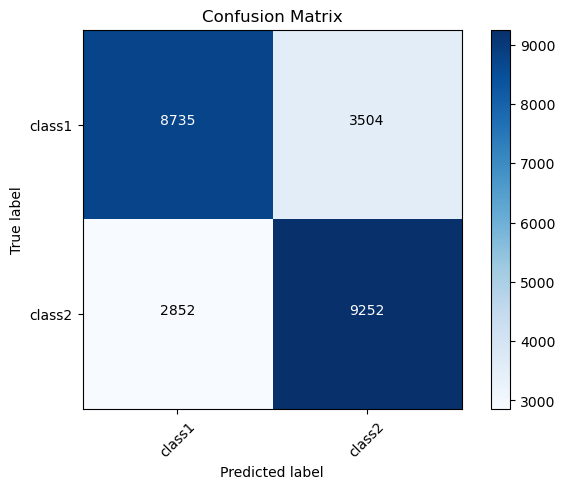

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


model = Model(X, y)
LR = model.LogisticRegression()
y_pred = LR.predict(model.X_test)
# create confusion matrix
cm = confusion_matrix(model.y_test, y_pred)

# plot the confusion matrix
plot_confusion_matrix(cm, classes=['class1', 'class2'], cmap=plt.cm.Blues)
plt.show()


In [2]:
model=M.DecisionTree()
import pickle

# Save the model to a .pkl file
with open('ddos_dt2.pkl', 'wb') as f:
    pickle.dump(model, f)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
criterion: gini, max depth: 6, max_leaf: 11
The Accuracy is : 95.07%
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11144
           1       1.00      0.91      0.95     13199

    accuracy                           0.95     24343
   macro avg       0.95      0.95      0.95     24343
weighted avg       0.95      0.95      0.95     24343

------------------------------------------------------------------------
--- 34.746211767196655 seconds ---


In [3]:
import pandas as pd

# Create a dictionary to store the model names and their corresponding accuracies, precisions, recalls, and f1-scores
results = {
    'Decision Tree': {
        'Accuracy': 0.9507,
        'Precision': 0.95,
        'Recall': 0.95,
        'F1-score': 0.95
    },
    'Linear Regression': {
        'Accuracy': 0.7389,
        'Precision': 0.74,
        'Recall': 0.74,
        'F1-score': 0.74
    }
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(results, orient='index')

# Print the DataFrame
print(df)


                   Accuracy  Precision  Recall  F1-score
Decision Tree        0.9507       0.95    0.95      0.95
Linear Regression    0.7389       0.74    0.74      0.74


In [3]:
X.columns

Index(['pktcount', 'byteperflow', 'tot_kbps', 'rx_kbps', 'flows', 'bytecount',
       'tot_dur', 'Protocol_ICMP', 'Protocol_TCP', 'Protocol_UDP'],
      dtype='object')

In [5]:
M=Model(X,y)
model_1=M.DecisionTree()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
criterion: gini, max depth: 6, max_leaf: 11
The Accuracy is : 95.07%
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11144
           1       1.00      0.91      0.95     13199

    accuracy                           0.95     24343
   macro avg       0.95      0.95      0.95     24343
weighted avg       0.95      0.95      0.95     24343

------------------------------------------------------------------------
--- 34.669068813323975 seconds ---
